##🚀drive mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the Homework directory in your Google Drive
%cd /content/drive/MyDrive/[2024-2025] AN2DL/Homework 1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/[2024-2025] AN2DL/Homework 1/'
/content


##📚importing libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
#import keras as tfk       #notice how I'm importing keras and not tensorflow.keras
#from keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")
# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
import os

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.1
Keras version -> 3.5.0
2.17.1


##📊Dataset

In previous explorations of the dataset we found some outliers and we decided to definitively remove them from out dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.load('/content/drive/MyDrive/[2024-2025] AN2DL Homework 1/training_set.npz')
X_import= data['images']
y_import = data['labels']
X=X_import[:11958]
y=y_import[:11958]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (11958, 96, 96, 3)
y shape: (11958, 1)


###visual inspection

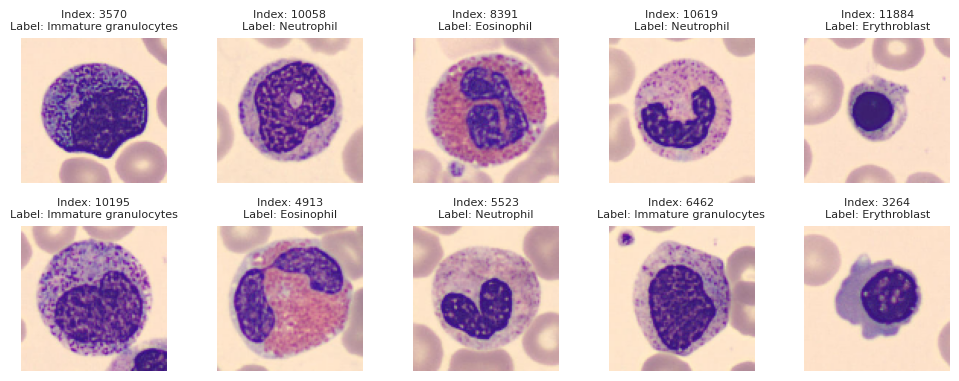

In [ ]:
# Define labels for each class
labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Number of images to display
num_images_to_display = 10

# Generate 10 random indices from the range of available data
random_indices = np.random.choice(min(len(X), len(y)), num_images_to_display, replace=False)

# Set up a 2x5 grid for displaying images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))  # 2 rows, 5 columns

for idx, i in enumerate(random_indices):
    row = idx // 5  # Determine row index (0 or 1)
    col = idx % 5   # Determine column index (0 to 4)

    axs[row, col].imshow(np.squeeze(X[i]), vmin=0., vmax=1.)
    axs[row, col].set_title(f'Index: {i}\nLabel: {labels[y[i][0]]}', fontsize=8)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# get shapes for each class
for class_idx, class_name in enumerate(labels):
    # Filter y for the current class index
    y_class = y[y == class_idx]
    print(f"Numerosity of {class_name} images: {y_class.shape}")


Numerosity of Basophil images: (852,)
Numerosity of Eosinophil images: (2181,)
Numerosity of Erythroblast images: (1085,)
Numerosity of Immature granulocytes images: (2026,)
Numerosity of Lymphocyte images: (848,)
Numerosity of Monocyte images: (993,)
Numerosity of Neutrophil images: (2330,)
Numerosity of Platelet images: (1643,)


###data processing

In [ ]:
# Normalize data to the range [0, 1]
X= (X / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

In [ ]:
# Data splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (9685, 96, 96, 3)
Training Label Shape: (9685, 8)
Validation Data Shape: (1077, 96, 96, 3)
Validation Label Shape: (1077, 8)


In [ ]:
# Freeing the memory
import gc
del X, y

gc.collect()

34

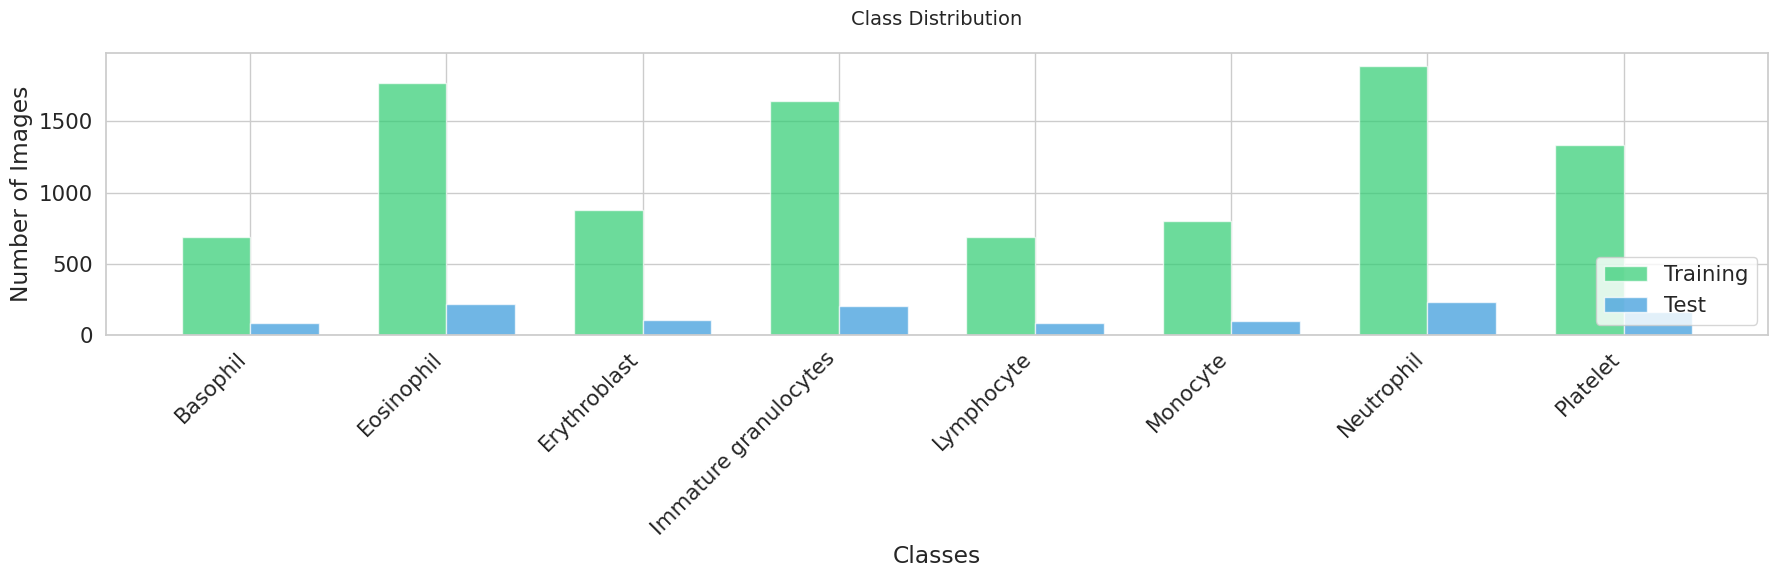

In [ ]:
def plot_class_distribution(y_train, y_test, class_names):
    # Set seaborn style for the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Convert one-hot encoded labels back to class indices
    y_train_indices = np.argmax(y_train, axis=1)  # Get class indices from one-hot encoded labels
    y_test_indices = np.argmax(y_test, axis=1)    # Get class indices from one-hot encoded labels


    # Calculate class distributions for training and test sets
    train_dist = np.bincount(y_train_indices) # Use class indices for bincount
    test_dist = np.bincount(y_test_indices)   # Use class indices for bincount

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#2ecc71', alpha=0.7)
    plt.bar(x + width / 2, test_dist, width, label='Test', color='#3498db', alpha=0.7)

    # Customise plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# Execute function to plot class distribution
plot_class_distribution(y_train, y_test, labels)

In [ ]:
#Check class numerosity
# Get shapes for each class in y_train
for class_idx, class_name in enumerate(labels):
    # Filter y_train for the current class index by checking if the one-hot column is 1
    y_class_train = y_train[np.argmax(y_train, axis=1) == class_idx]
    print(f"Numerosity of {class_name} images in training set: {y_class_train.shape[0]}")

print("\n")

Numerosity of Basophil images in training set: 690
Numerosity of Eosinophil images in training set: 1767
Numerosity of Erythroblast images in training set: 878
Numerosity of Immature granulocytes images in training set: 1641
Numerosity of Lymphocyte images in training set: 687
Numerosity of Monocyte images in training set: 804
Numerosity of Neutrophil images in training set: 1887
Numerosity of Platelet images in training set: 1331




###balancing data using synthetic data

Since the number of images is very different across classes, by applying transformations to the images of each class, we balance the class distribution to match the size of the largest class

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import random

# Calculate the target count based on the most numerous class in `y_train`
unique, counts = np.unique(y_train.argmax(axis=1), return_counts=True)
class_counts = dict(zip(unique, counts))
target_count = max(class_counts.values())

# Initialize the data generator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare lists to store the augmented images and labels
augmented_images = []
augmented_labels = []

# Augment underrepresented classes in `X_train` until each reaches the target count
for class_label, count in class_counts.items():
    if count < target_count:
        # Filter `X_train` to get only images of the current class
        indices = np.where(y_train.argmax(axis=1) == class_label)[0]
        X_train_class = X_train[indices]

        # Calculate the number of augmentations needed
        num_augmentations = target_count - count

        i = 0
        while i < num_augmentations:
            # Randomly select an image from `X_train_class`
            img = random.choice(X_train_class)
            x = img.reshape((1,) + img.shape)  # Reshape to add batch dimension

            # Generate one augmented image
            for batch in datagen.flow(x, batch_size=1):
                augmented_images.append(batch[0])  # Add augmented image
                augmented_labels.append(class_label)  # Add class label
                i += 1
                break  # Generate only one augmented image per selected image

# Convert augmented data to NumPy arrays
augmented_images = np.array(augmented_images)
# Convert `augmented_labels` to one-hot encoding to match `y_train` shape
augmented_labels = to_categorical(augmented_labels, num_classes=y_train.shape[1])

# Append the augmented images and labels back to `X_train` and `y_train`
X_train_balanced = np.concatenate((X_train, augmented_images), axis=0)
y_train_balanced = np.concatenate((y_train, augmented_labels), axis=0)

# Verify the new class counts in `y_train_balanced`
unique_balanced, counts_balanced = np.unique(y_train_balanced.argmax(axis=1), return_counts=True)
class_counts_balanced = dict(zip(unique_balanced, counts_balanced))

# Print the final shape and counts of each class in `X_train_balanced`
print("Class counts after balancing:")
for class_label, count in class_counts_balanced.items():
    print(f"Class {class_label}: {count}")
print("\nFinal shapes:")
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")


Class counts after balancing:
Class 0: 1887
Class 1: 1887
Class 2: 1887
Class 3: 1887
Class 4: 1887
Class 5: 1887
Class 6: 1887
Class 7: 1887

Final shapes:
X_train_balanced shape: (15096, 96, 96, 3)
y_train_balanced shape: (15096, 8)


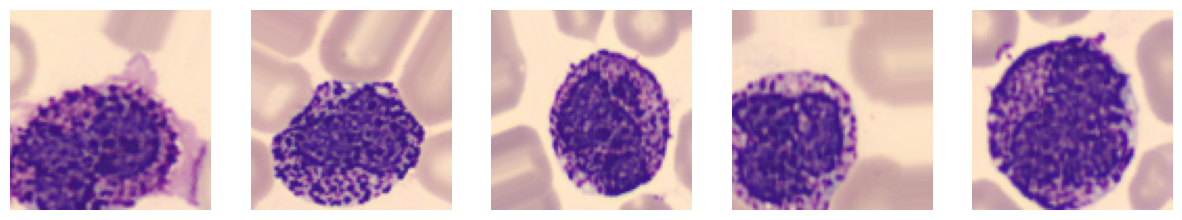

In [ ]:
# Check if the augmentation is reliable
# Display the first 5 augmented images to verify
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 15))

for i in range(num_images_to_display):
    # Multiply by 255 to bring pixel values back to [0, 255] range for display
    axes[i].imshow(augmented_images[i])
    axes[i].axis('off')

plt.show()

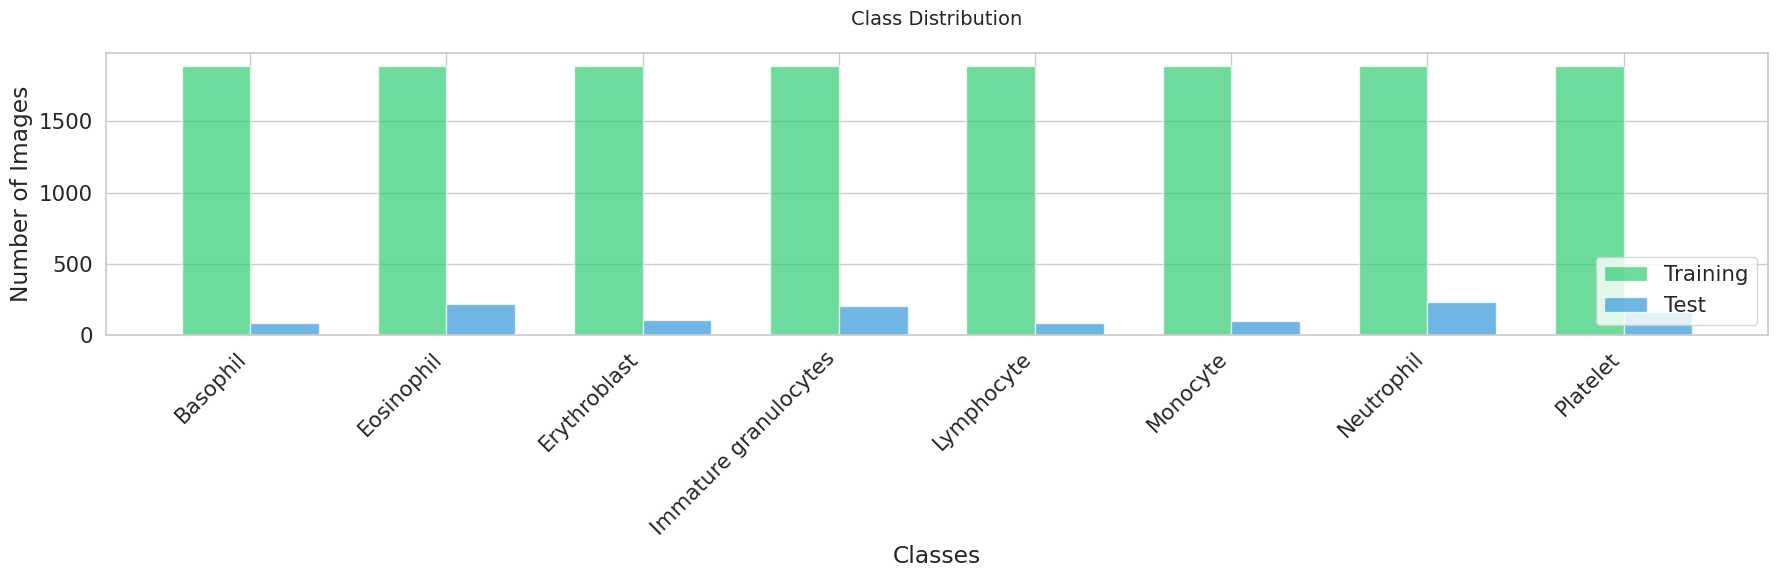

In [ ]:
# Execute function to plot new class distribution
plot_class_distribution(y_train_balanced, y_test, labels)

We can now see how each class is represented with the same number of images in the training set

In [ ]:
import gc

# Freeing the memory
del X_train
del augmented_images
del augmented_labels
gc.collect()

In [ ]:
# Input shape for the model
input_shape = X_train_balanced.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.5 MB/s eta 0:00:00


###preparing the dataset

Prepare the training dataset by applying RandAugment to the images, and the validation dataset (also setting the batch size)

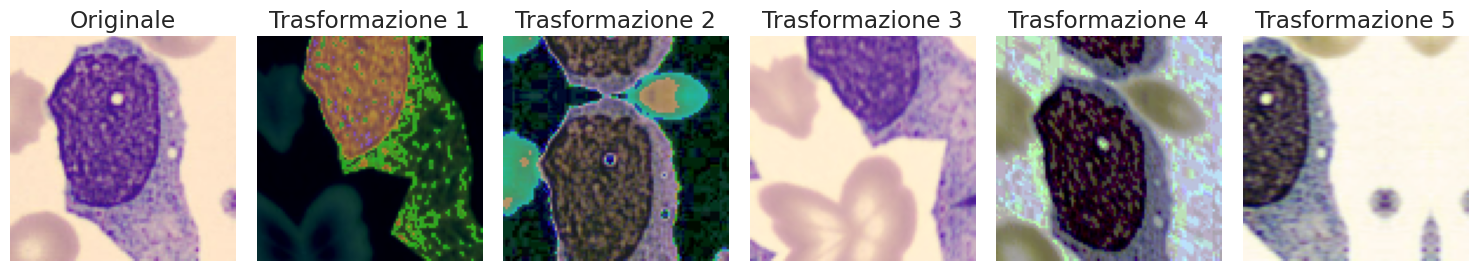

In [ ]:
import keras_cv

augmentation_layers = keras_cv.layers.RandAugment(
    value_range=(0, 255),  #It has to fit the image range
    augmentations_per_image=4,  #Transformations per image
    magnitude=0.3,  #Magnitude of the transformation
    magnitude_stddev=0.15,  #Standard deviation of the magnitude
    rate=1.0,  # Probability of applying the transformation
    geometric=True,
)


image=X_train_balanced[:5]*255

# Applies the augmentation pipeline to the image
augmented_images = []
for _ in range(5):  # Generates 5 transformations to visualize the variations
    augmented_image = augmentation_layers(image, training=True)
    augmented_images.append(augmented_image[0].numpy())  # Adds the transformation to the list

# Displays the images
plt.figure(figsize=(15, 5))

# Displays the original image
plt.subplot(1, 6, 1)
plt.imshow(image[0].astype(np.uint8))
plt.title("Originale")
plt.axis('off')

# Displays the transformed images
for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(aug_img.astype(np.uint8))
    plt.title(f"Trasformazione {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Freeing the memory
del augmentation_layers

gc.collect()

In [ ]:
import tensorflow as tf
import keras_cv

# Defines RandAugment with parameters:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),  # Adjusts the image range (0-255)
    augmentations_per_image=3,  # Number of transformations per image
    magnitude=0.3,  # Intensity of the transformations
    magnitude_stddev=0.15,  # Standard deviation for magnitude
    rate=1.0,  # Probability of applying each transformation
)

# Creation of the datasets
batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((X_train_balanced*255, y_train_balanced))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val*255, y_val))

train_ds = train_ds.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

# Function to apply RandAugment
def apply_rand_augment(images, labels):
    images = rand_augment(images)  # Applies RandAugment only to the images
    return images, labels

# Preprocessing function to normalize the images
def preprocess_for_model(images, labels):
    images = tf.cast(images, tf.float32)
    labels=tf.cast(labels, tf.float32)
    return images, labels

# Preprocessing on the datasets
train_ds = train_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
# Applies RandAugment to the training dataset
train_ds = train_ds.map(apply_rand_augment, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)

# Optimizations
train_ds = train_ds.cache()  # Caches in memory
train_ds = train_ds.shuffle(buffer_size=1000)  # Shuffles the dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetches the batches
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

##💡EfficientNetV2B2

###transfer learning

We apply transfer learning: we import the EfficientNetV2-B2 model, pre-trained on the Imagenet dataset, freezing all parameters of all layers, but excluding the final classification layer.
From this base model, we build our model by adding a Dropout layer and the final Dense classification layer.
We use Categorical Crossentropy as the loss function and Adam as the optimizer


In [ ]:
from keras.applications import EfficientNetV2B2
import keras_cv

efficient=EfficientNetV2B2(include_top=False, weights='imagenet',  pooling='avg', input_shape=(96, 96, 3)) # Import the EfficientNetV2-B2 model
efficient.trainable=False # Freeze all layers for initial transfer learning

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 1408)                │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_conv (Conv2D)    │ (None, 24, 24, 64)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_activation       │ (None, 24, 24, 64)          │              

 Total params: 8,780,646 (33.50 MB)

 Trainable params: 11,272 (44.03 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

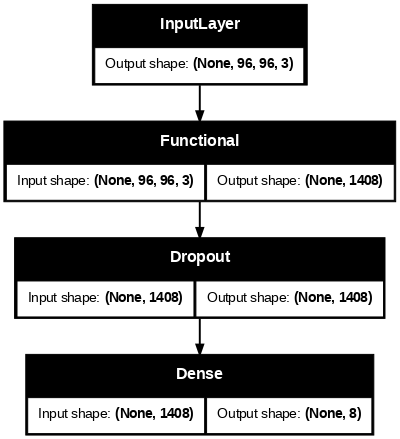

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(96, 96, 3))

x = efficient(inputs)

# Add GlobalAveragePooling and Dropout
#x = tfkl.GlobalAveragePooling2D(name='gap')(x) #already included
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add a final Dense layer for classification
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Create the model
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
model = models.Model(inputs, outputs)

# Compile the model with categorical cross-entropy loss and Adam optimiser
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['accuracy'])

#Display model summary
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, show_shapes=True, dpi=70)


Above, you can see the structure of the created model and the number of parameters

We can train the model, also using early stopping to prevent overfitting and reduce computational time

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=1000,
    validation_data=validation_dataset,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
# Replace decimal point in accuracy with underscore, or convert to an integer
formatted_accuracy = str(final_val_accuracy).replace('.', '_')
model_filename = 'bloodcells_tl_efficientv2b2_' + str(formatted_accuracy) + '.keras'
model.save(model_filename)
print(f"Model saved as {model_filename} in /content/drive/MyDrive/[2024-2025] AN2DL/Homework 1/")

# Free memory by deleting the model instance
del model

Epoch 1/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 144s 300ms/step - accuracy: 0.2464 - loss: 1.9293 - val_accuracy: 0.6555 - val_loss: 1.1215
Epoch 2/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5426 - loss: 1.2852 - val_accuracy: 0.7242 - val_loss: 0.9284
Epoch 3/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5932 - loss: 1.1525 - val_accuracy: 0.7734 - val_loss: 0.8092
Epoch 4/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6267 - loss: 1.0424 - val_accuracy: 0.8013 - val_loss: 0.7316
Epoch 5/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6451 - loss: 0.9964 - val_accuracy: 0.7846 - val_loss: 0.7293
Epoch 6/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6611 - loss: 0.9695 - val_accuracy: 0.7976 - val_loss: 0.7061
Epoch 7/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6720 - loss: 0.9281 - val_accuracy: 0.8301 - val_loss: 0.6162
Epoch 8/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6763 - loss

###fine tuning

Now let's proceed with fine-tuning: from the previously trained model, we freeze only the first 124 layers, allowing all the other parameters to be trained.
The loss function remains the same, while we continue using Adam as the optimizer, but with a smaller learning rate

####freezing 124 layers

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 1408)                │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_conv (Conv2D)    │ (None, 24, 24, 64)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_activation       │ (None, 24, 24, 64)          │              

 Total params: 8,803,192 (33.58 MB)

 Trainable params: 11,272 (44.03 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

 Optimizer params: 22,546 (88.07 KB)

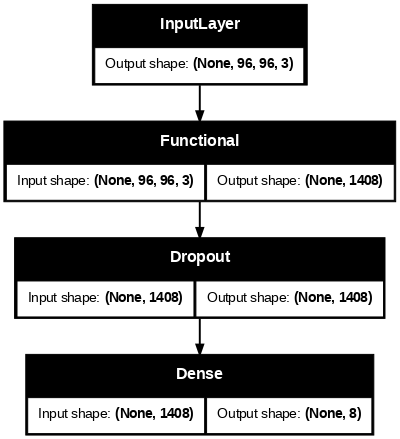

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('bloodcells_tl_efficientv2b2_88_21.keras') # Load the pre-trained model

#Display summary
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, show_shapes=True, dpi=70)


In [ ]:
# Set all layers in efficientnetb2 as trainable
model.get_layer('efficientnetv2-b2').trainable = True

# Set all layers as non-trainable
for layer in model.get_layer('efficientnetv2-b2').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(model.get_layer('efficientnetv2-b2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
       # print(i, layer.name, type(layer).__name__, layer.trainable)

# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(model.get_layer('efficientnetv2-b2').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(model.get_layer('efficientnetv2-b2').layers):
    print(i, layer.name, layer.trainable)


model.summary(expand_nested=True)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
3

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 1408)                │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_conv (Conv2D)    │ (None, 24, 24, 64)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_activation       │ (None, 24, 24, 64)          │              

 Total params: 8,803,192 (33.58 MB)

 Trainable params: 7,573,904 (28.89 MB)

 Non-trainable params: 1,206,742 (4.60 MB)

 Optimizer params: 22,546 (88.07 KB)

Above, we can see which layers are frozen and which are now trainable, along with the number of trainable and non-trainable parameters

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 1408)                │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 16)          │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 16)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_conv (Conv2D)    │ (None, 24, 24, 64)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_activation       │ (None, 24, 24, 64)          │              

 Total params: 8,780,646 (33.50 MB)

 Trainable params: 7,573,904 (28.89 MB)

 Non-trainable params: 1,206,742 (4.60 MB)

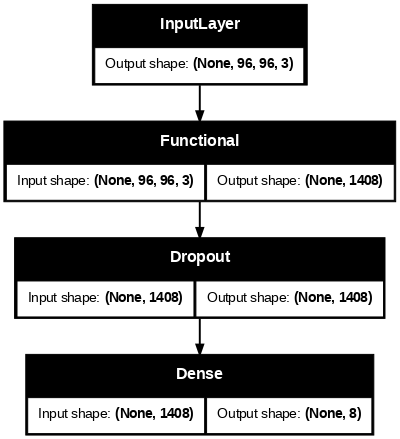

In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True,
)

# Store the callback in a list
callbacks = [early_stopping]


# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

# Display a summary of the model architecture
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
#Train the model
history = model.fit(
    train_ds,
    validation_data=validation_dataset,
    epochs=1000,
    callbacks=callbacks
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Format the filename to avoid special character issues
# Replace decimal point in accuracy with underscore, or convert to an integer
formatted_accuracy = str(final_val_accuracy).replace('.', '_')
model_filename = f'EfficientV2B2_124layers_{formatted_accuracy}.keras'

# Save model to the Homework directory
model.save(model_filename)
print(f"Model saved as {model_filename} in /content/drive/MyDrive/[2024-2025] AN2DL/Homework 1/")

# Free memory by deleting the model instance
del model

Epoch 1/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 88s 350ms/step - accuracy: 0.7229 - loss: 0.7706 - val_accuracy: 0.8737 - val_loss: 0.3632
Epoch 2/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8376 - loss: 0.4454 - val_accuracy: 0.9239 - val_loss: 0.2048
Epoch 3/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.8715 - loss: 0.3600 - val_accuracy: 0.9396 - val_loss: 0.1591
Epoch 4/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8988 - loss: 0.2843 - val_accuracy: 0.9350 - val_loss: 0.1620
Epoch 5/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9229 - loss: 0.2166 - val_accuracy: 0.9369 - val_loss: 0.1583
Epoch 6/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9282 - loss: 0.1981 - val_accuracy: 0.9359 - val_loss: 0.1570
Epoch 7/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9526 - loss: 0.1413 - val_accuracy: 0.9554 - val_loss: 0.1412
Epoch 8/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9502 - loss

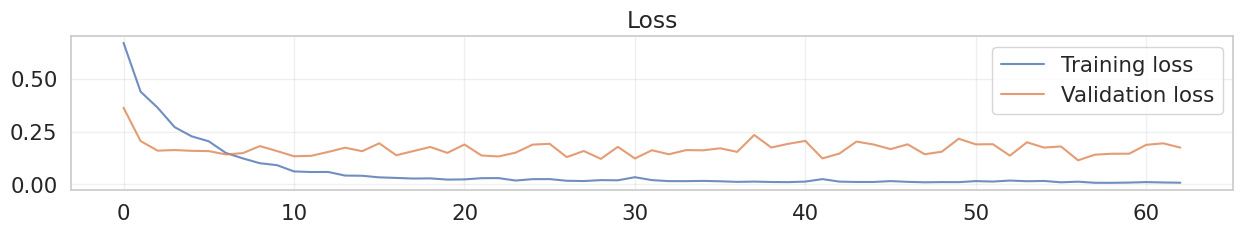

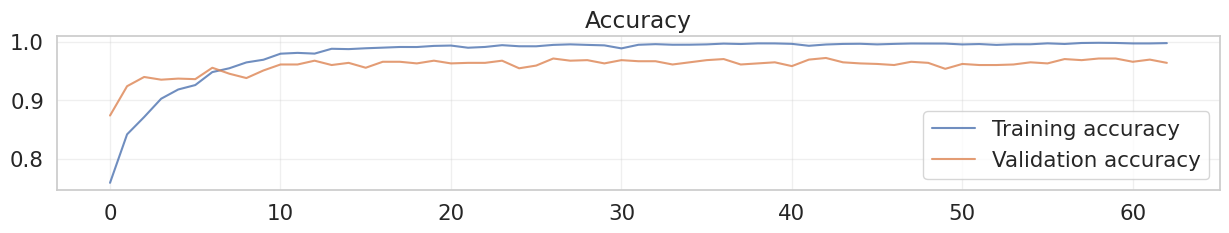

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


Above, you can see the progress of the Loss function and of the accuracy for both Training and Validation during the model training

#####make inference

We can now use the trained model to see how it performs on a test dataset, never seen by the model before

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-b2 (Functional)      │ (None, 1408)                 │     8,769,374 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling (Rescaling)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ normalization (Normalization)  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv (Conv2D)             │ (None, 48, 48, 32)           │           864 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_bn (BatchNormalization)   │ (None, 48, 48, 32)           │           128 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_activation (Activation)   │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_conv (Conv2D)  │ (None, 48, 48, 16)           │         4,608 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_bn             │ (None, 48, 48, 16)           │            64 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_activation     │ (None, 48, 48, 16)           │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_conv (Conv2D)  │ (None, 48, 48, 16)           │         2,304 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_bn             │ (None, 48, 48, 16)           │            64 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_project_activation     │ (None, 48, 48, 16)           │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_drop (Dropout)         │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1b_add (Add)              │ (None, 48, 48, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2a_expand_conv (Conv2D)   │ (None, 24, 24, 64)           │         9,216 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2a_expand_b

 Total params: 23,928,456 (91.28 MB)

 Trainable params: 7,573,904 (28.89 MB)

 Non-trainable params: 1,206,742 (4.60 MB)

 Optimizer params: 15,147,810 (57.78 MB)

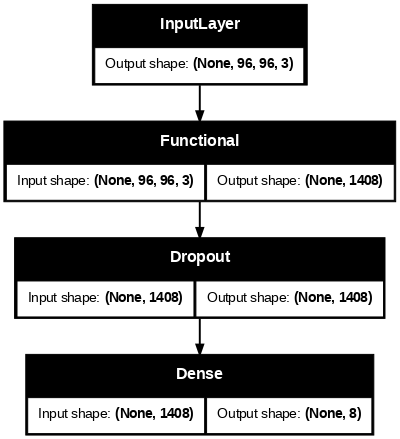

In [ ]:
# Load the saved model
model = tfk.models.load_model('EfficientV2B2_124layers_97_21.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test*255, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1196, 8)


Accuracy score over the test set: 0.9674
Precision score over the test set: 0.9677
Recall score over the test set: 0.9674
F1 score over the test set: 0.9674


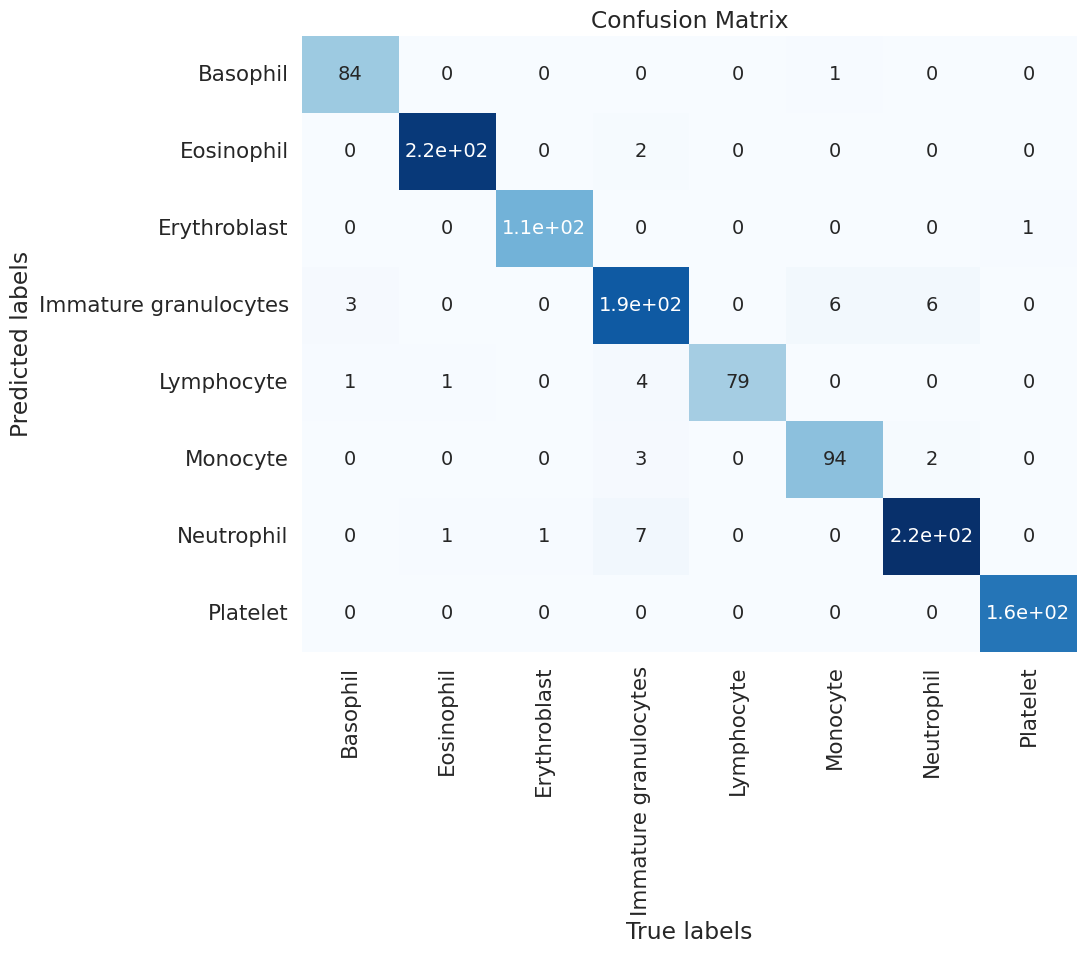

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Convert predictions and ground truth to class labels
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display metrics
accuracy = accuracy_score(true_classes, pred_classes)
precision = precision_score(true_classes, pred_classes, average='weighted')
recall = recall_score(true_classes, pred_classes, average='weighted')
f1 = f1_score(true_classes, pred_classes, average='weighted')

print(f'Accuracy score over the test set: {round(accuracy, 4)}')
print(f'Precision score over the test set: {round(precision, 4)}')
print(f'Recall score over the test set: {round(recall, 4)}')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Define class labels (e.g., ['Class 0', 'Class 1', ...])
class_labels = labels  # Replace `labels` with your list of actual class names

# Plot the confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()


Above, we can see the results from the predictions made on the test dataset: the confusion matrix is shown and accuracy, precision, recall and F1 score are calculated

#####explainability

We visualize model predictions on test images, displaying both the true class and predicted class, along with the activations from the first convolutional layer

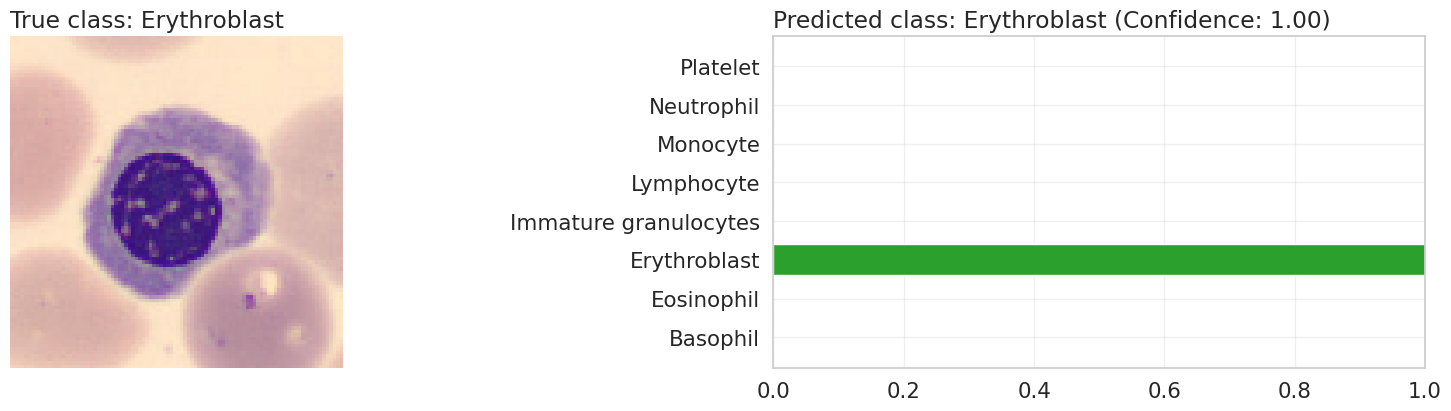

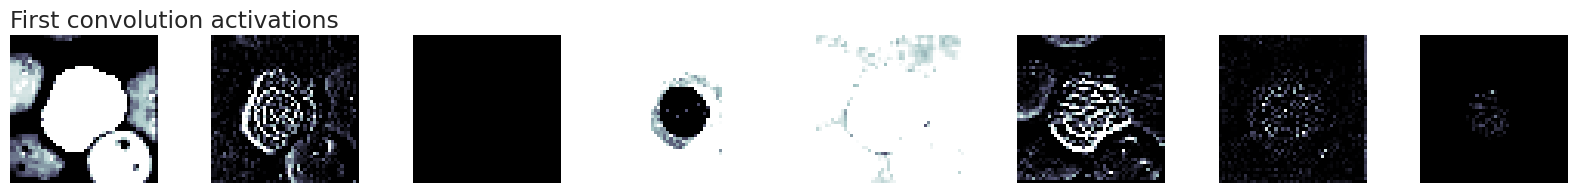

In [ ]:
# Function to extract activations from the convolutional layers
def extract_activations(model, X, num_images):
   # Extract all layers from the model
    layers = model.get_layer('efficientnetv2-b2').layers

    # Find the first convolutional layer
    first_conv_index = None
    for i, layer in enumerate(layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            first_conv_index = i
            break

    if first_conv_index is None:
        raise ValueError("Il modello non contiene un layer Conv2D")

    # Extract activations from the first convolutional layer
    first_conv = tf.keras.Sequential(layers[:first_conv_index + 1])
    first_activations = first_conv(X[:num_images])


    return first_activations

# Function to visualize the model and activations
def visualize(model, X, y, unique_labels, num_images=50, display_activations=True):

    # Extract activations
    first_activations = extract_activations(model, X, num_images)

    # Select a random image for prediction and visualization
    image = np.random.randint(0, num_images)
    predictions = model.predict(np.expand_dims(X[image], axis=0), verbose=0)
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Create layout to display the image and predictions
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display the selected image with the true class
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {unique_labels[np.argmax(y[image])]}", loc='left')
    if X[image].shape[-1] == 1:  # If the image is grayscale
        ax1.imshow(np.squeeze(X[image]/255), cmap='bone', vmin=0., vmax=1.)
    else:  # If the image is color
        ax1.imshow(np.squeeze(X[image]/255), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display the prediction as a bar chart
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(unique_labels, np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions, axis=0)):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)

    plt.show()

    # Display activations if requested
    if display_activations:
        # Show activations from the first convolutional layer
        fig, axes = plt.subplots(1, 8, figsize=(16, 14))
        for i in range(8):  # Display the first 8 activations
            ax = axes[i]
            ax.imshow(first_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('First convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

# Example usage
visualize(model, X_test*255, y_test, labels, display_activations=True)

We use Grad-CAM to visualize which regions of an image influence the model’s predictions: it highlights important areas by superimposing a heatmap onto the original image, helping to understand the model's decision-making process

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


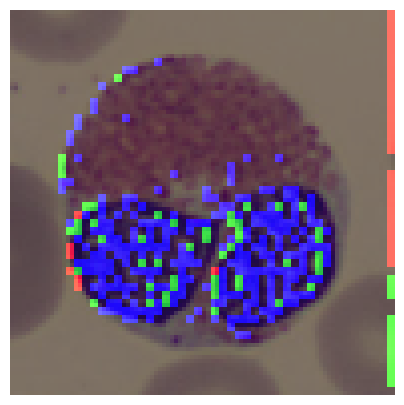

In [ ]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import keras

last_conv_layer_name = "stem_conv"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


idx=8
img_array = keras.utils.img_to_array(X_test[idx]*255)
# We add a dimension to transform our array into a "batch"
# of size (1, 299, 299, 3)
img_array = np.expand_dims(img_array, axis=0)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model.get_layer('efficientnetv2-b2'), last_conv_layer_name)

def display_gradcam(img_array, heatmap,  alpha=0.7):  # Increase alpha for better visibility

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Apply a "hot" colormap for better contrast
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Convert to PIL image and resize to match the original image dimensions
    jet_heatmap = PILImage.fromarray(np.uint8(jet_heatmap))  # Ensure it's uint8
    jet_heatmap = jet_heatmap.resize((96, 96))  # Resize to match img
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 255 * alpha + img_array[0]*0.5  # img_array[0] to get the original image

    # Normalize the superimposed image for better visibility
    superimposed_img = np.clip(superimposed_img, 0, 255)

    # Display the Grad-CAM result
    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img / 255.0)
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()


display_gradcam(img_array, heatmap)

We extract features from a selected image using the pre-trained model, computing the similarity between the selected image and others in the dataset and then visualizing the top 10 most similar images with their corresponding labels

In [ ]:
# Extract and preprocess a single image for feature extraction
index = 8
image = np.expand_dims(X_test[index], axis=0)

fen = model.get_layer('efficientnetv2-b2')
# Preprocess the image and predict its features
image_features = fen.predict(image * 255, verbose=0)

# Display the selected image
plt.imshow(X_test[index])
plt.xticks([])
plt.yticks([])
plt.show()

# Preprocess the dataset and extract features from the first 100 images
dataset_features = fen.predict(X_train[:100] * 255, batch_size=32, verbose=0)

# Compute the distances between the selected image features and those of the entire dataset
distances = np.mean(np.square(dataset_features - image_features), axis=-1)

# Sort the images based on the distances (similarity to the selected image)
ordered_images = X_train[distances.argsort()]

# Get the labels for the ordered images (convert to categorical format if needed)
ordered_labels = np.argmax(y_train[:100][distances.argsort()], axis=1)

# Display the top 10 most similar images with their labels
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(25, 20))
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(ordered_images[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Label: {labels[ordered_labels[i]]}")  # Add the label
plt.tight_layout()
plt.show()

##🗂️preparing the submission

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('EfficientV2B2_124layers_97_21.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py EfficientV2B2_124layers_97_21.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 55%)
  adding: EfficientV2B2_124layers_97_21.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>